#  PASO 1: CREACIÓN Y CARGA DEL DATASET SINTÉTICO

Simularemos consumo horario de un cliente durante 90 días (3 meses), incluyendo algunas anomalías artificiales.

**Objetivo de este paso:**

Crear un dataframe con columnas fecha_hora y consumo_kw.

Simular una tendencia estacional con ruido.

Agregar anomalías (valores fuera de rango esperado).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Estilo para los gráficos
sns.set(style="whitegrid")

# Crear un rango de fechas por hora durante 90 días
fecha_hora = pd.date_range(start='2023-01-01', end='2023-03-31 23:00:00', freq='H')

# Simular consumo base: patrón diario + estacionalidad + ruido
np.random.seed(42)
n = len(fecha_hora)
consumo_base = 1.5 + 0.5 * np.sin(2 * np.pi * (fecha_hora.hour) / 24)  # patrón diario
estacionalidad = 0.3 * np.sin(2 * np.pi * fecha_hora.dayofyear / 365)  # patrón anual
ruido = np.random.normal(0, 0.1, n)
consumo_kw = consumo_base + estacionalidad + ruido

# Asegurarse de que consumo_kw sea un array mutable de NumPy antes de añadir anomalías.
consumo_kw = np.array(consumo_kw)

# Introducir algunas anomalías artificiales
anomalías_idx = np.random.choice(n, size=10, replace=False)
consumo_kw[anomalías_idx] += np.random.uniform(3, 6, size=10)  # consumos muy altos

# Crear el DataFrame
df = pd.DataFrame({
    'fecha_hora': fecha_hora,
    'consumo_kw': consumo_kw
})

# Mostrar primeras filas
df.head()

/tmp/ipython-input-1-280912548.py:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  fecha_hora = pd.date_range(start='2023-01-01', end='2023-03-31 23:00:00', freq='H')


,fecha_hora,consumo_kw
0,2023-01-01 00:00:00,1.554835
1,2023-01-01 01:00:00,1.620747
2,2023-01-01 02:00:00,1.819933
3,2023-01-01 03:00:00,2.011020
4,2023-01-01 04:00:00,1.914761


# ¿Qué hicimos acá?

Simulamos consumo por hora durante 3 meses.

Le pusimos un patrón diario (picos al mediodía y noche).

Agregamos variaciones estacionales suaves.

Introdujimos 10 anomalías con consumos anormalmente altos.

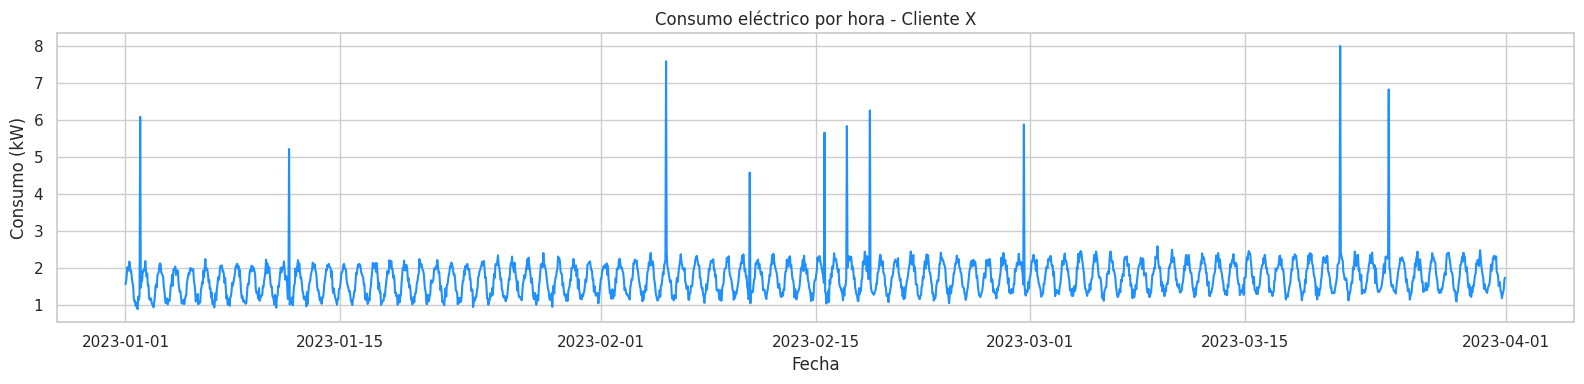

In [2]:
# Gráfico de la serie temporal
plt.figure(figsize=(16, 4))
plt.plot(df['fecha_hora'], df['consumo_kw'], label='Consumo (kW)', color='dodgerblue')
plt.title('Consumo eléctrico por hora - Cliente X')
plt.xlabel('Fecha')
plt.ylabel('Consumo (kW)')
plt.tight_layout()
plt.show()

#¿Qué deberías observar?

Ciclos diarios claros (subidas y bajadas cada 24 horas).

Variación a lo largo de los días.

Picos abruptos que son las anomalías agregadas artificialmente.

Conclusión: La señal tiene estacionalidad + ruido + anomalías, como en muchos casos reales de sensores o registros de actividad.

# PASO 2: ANÁLISIS EXPLORATORIO DE DATOS (EDA) Y PREPROCESAMIENTO

 Objetivo de este paso:

- Realizar estadísticas descriptivas para entender la distribución del consumo.

- Verificar si hay datos faltantes (aunque en este dataset simulado no debería haberlos).

- Visualizar tendencias, estacionalidad y patrones horarios.

- Preparar la serie temporal para el modelado (por ejemplo, asegurarnos de que el índice sea de tipo datetime).

--- Información del DataFrame ---
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2160 entries, 2023-01-01 00:00:00 to 2023-03-31 23:00:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   consumo_kw  2160 non-null   float64
dtypes: float64(1)
memory usage: 33.8 KB

--- Estadísticas Descriptivas del Consumo ---
count    2160.000000
mean        1.715570
std         0.488763
min         0.880971
25%         1.368982
50%         1.699541
75%         2.015451
max         7.991338
Name: consumo_kw, dtype: float64


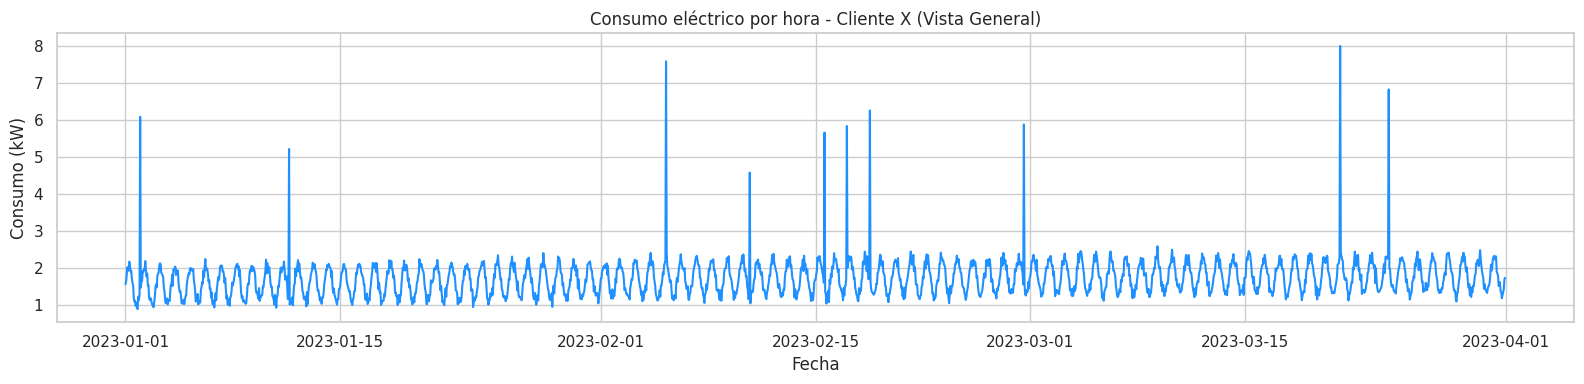

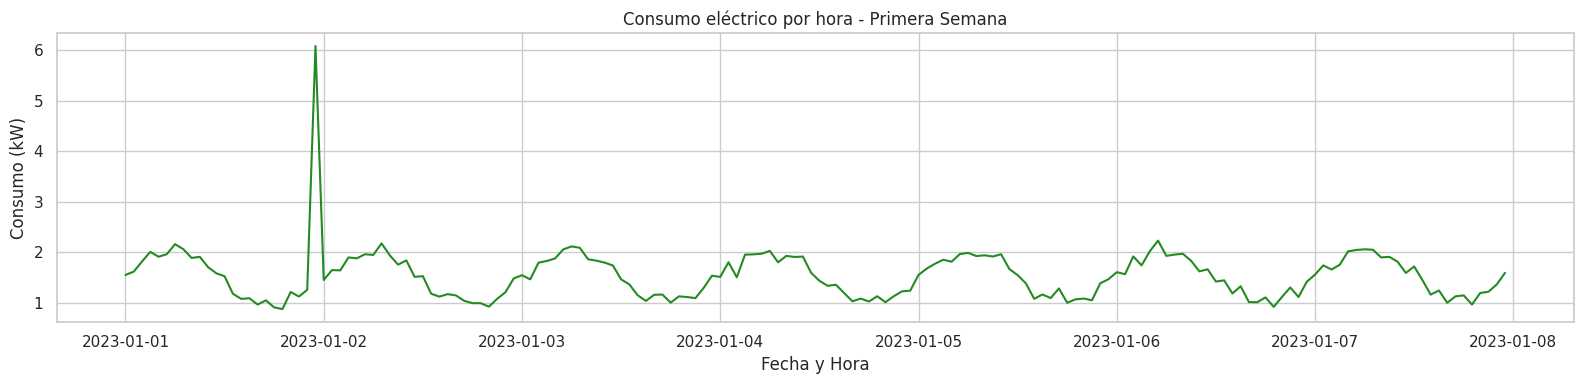

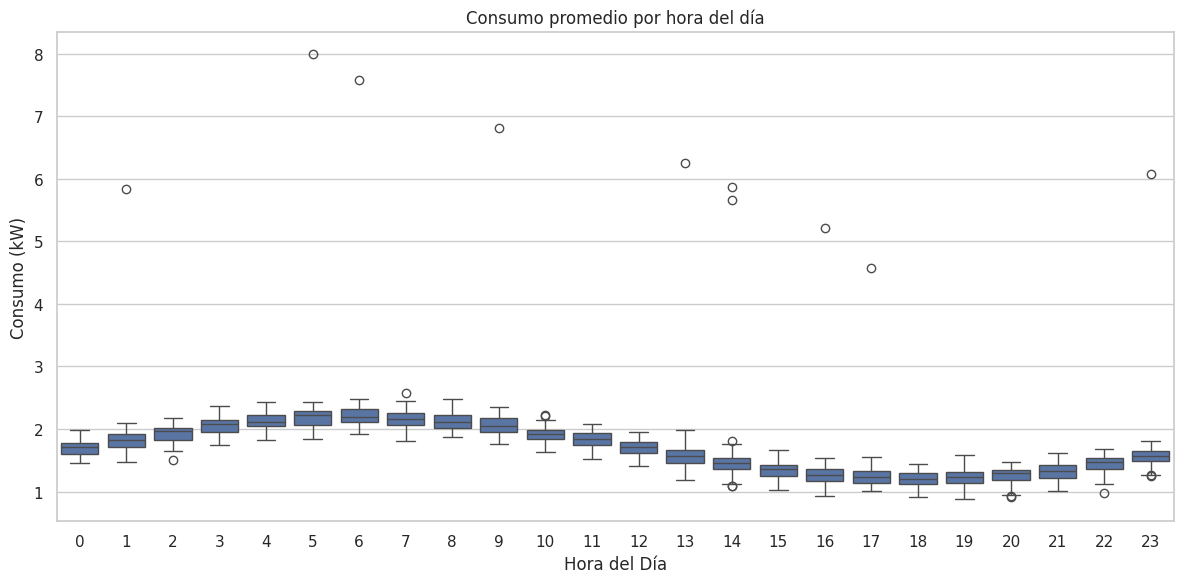

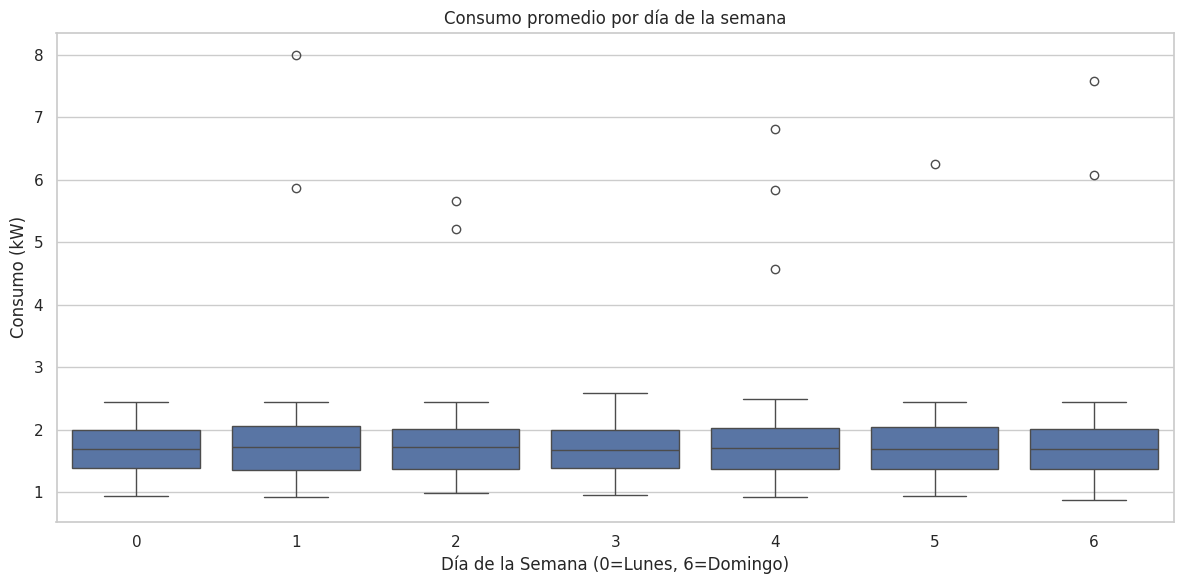

In [3]:
# Asegurarse de que 'fecha_hora' sea el índice y de tipo datetime
df['fecha_hora'] = pd.to_datetime(df['fecha_hora'])
df = df.set_index('fecha_hora')

print("--- Información del DataFrame ---")
df.info()

print("\n--- Estadísticas Descriptivas del Consumo ---")
print(df['consumo_kw'].describe())

# Visualización de la serie temporal (ya la hicimos, pero la re-graficamos para recordar)
plt.figure(figsize=(16, 4))
plt.plot(df.index, df['consumo_kw'], label='Consumo (kW)', color='dodgerblue')
plt.title('Consumo eléctrico por hora - Cliente X (Vista General)')
plt.xlabel('Fecha')
plt.ylabel('Consumo (kW)')
plt.tight_layout()
plt.show()

# Visualización de un período más corto para ver el patrón diario en detalle
plt.figure(figsize=(16, 4))
plt.plot(df.index[:24*7], df['consumo_kw'][:24*7], label='Consumo (kW)', color='forestgreen')
plt.title('Consumo eléctrico por hora - Primera Semana')
plt.xlabel('Fecha y Hora')
plt.ylabel('Consumo (kW)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Análisis de la estacionalidad diaria
plt.figure(figsize=(12, 6))
df['hora_del_dia'] = df.index.hour
sns.boxplot(x='hora_del_dia', y='consumo_kw', data=df)
plt.title('Consumo promedio por hora del día')
plt.xlabel('Hora del Día')
plt.ylabel('Consumo (kW)')
plt.tight_layout()
plt.show()

# Análisis de la estacionalidad semanal (si tuviéramos más datos, aquí se vería más claro)
plt.figure(figsize=(12, 6))
df['dia_de_la_semana'] = df.index.dayofweek # Lunes=0, Domingo=6
sns.boxplot(x='dia_de_la_semana', y='consumo_kw', data=df)
plt.title('Consumo promedio por día de la semana')
plt.xlabel('Día de la Semana (0=Lunes, 6=Domingo)')
plt.ylabel('Consumo (kW)')
plt.tight_layout()
plt.show()

# Eliminar la columna temporal 'hora_del_dia' y 'dia_de_la_semana' si no se usarán en el modelo
df = df.drop(columns=['hora_del_dia', 'dia_de_la_semana'])

# ¿Qué hicimos y qué deberías observar?

- Asegurar el Índice Temporal: Convertimos la columna fecha_hora a tipo datetime y la establecimos como el índice del DataFrame. Esto es fundamental para trabajar con series temporales en Pandas, ya que permite operaciones basadas en el tiempo de forma eficiente.

- df.info(): Nos muestra que no hay valores nulos y que el índice ahora es DatetimeIndex.

  Estadísticas Descriptivas:

- df['consumo_kw'].describe(): Nos da un resumen de las estadísticas clave del consumo:

- count: El número total de registros.

- mean: El consumo promedio.

- std: La desviación estándar, que nos dice qué tan dispersos están los datos respecto a la media. Un valor alto podría indicar mucha variabilidad.

- min y max: Los valores mínimo y máximo de consumo. Aquí, los valores máximos probablemente correspondan a las anomalías que inyectamos.

- 25%, 50% (median), 75%: Los cuartiles. Nos dan una idea de la distribución de los datos. Por ejemplo, el 50% de los datos están por debajo de la mediana. La diferencia entre el 75% y el 25% (Rango Intercuartílico - IQR) es una medida de dispersión robusta a los outliers.


  Visualización de la Serie Temporal:

- Vista General: La primera gráfica (Consumo eléctrico por hora - Cliente X) te permite ver el comportamiento general durante los 3 meses. Los picos que mencionamos anteriormente (las anomalías) deberían ser claramente visibles como aumentos repentinos en el consumo.

- Vista Detallada (Primera Semana): Al hacer zoom en la primera semana, puedes observar con mayor claridad el patrón diario recurrente. Notarás subidas y bajadas en el consumo que se repiten aproximadamente cada 24 horas. Esto es la estacionalidad diaria.

- Análisis de la Estacionalidad Diaria (Boxplot por Hora):

- Creamos una columna hora_del_dia extrayendo la hora del índice.

- El boxplot (Consumo promedio por hora del día) muestra la distribución del consumo para cada hora del día. Deberías ver que el consumo es más alto en ciertas horas (por ejemplo, tarde-noche) y más bajo en otras (madrugada), confirmando el patrón diario. Los "bigotes" del boxplot y los puntos individuales más allá de ellos indican la dispersión y la presencia de outliers (posibles anomalías) en cada hora.

- Análisis de la Estacionalidad Semanal (Boxplot por Día de la Semana):

- Similar al anterior, creamos dia_de_la_semana (0=Lunes a 6=Domingo).

- Este boxplot (Consumo promedio por día de la semana) te mostrará si hay diferencias significativas en el consumo entre los días de la semana (por ejemplo, si el consumo es menor los fines de semana). En nuestro dataset simulado, la estacionalidad semanal podría no ser tan pronunciada como la diaria, pero en datos reales suele ser importante.

- Limpieza de columnas temporales: Eliminamos las columnas auxiliares hora_del_dia y dia_de_la_semana ya que las usamos solo para el EDA. Para el modelado de series temporales, el índice temporal suele ser suficiente.

# Conclusión:

Este EDA nos ha permitido confirmar la presencia de estacionalidad diaria, identificar el rango general de consumo y visualizar las anomalías inyectadas. También confirmamos que nuestros datos están limpios y en el formato correcto para el siguiente paso.



# PASO 3: MODELADO DE SERIES TEMPORALES (ARIMA)

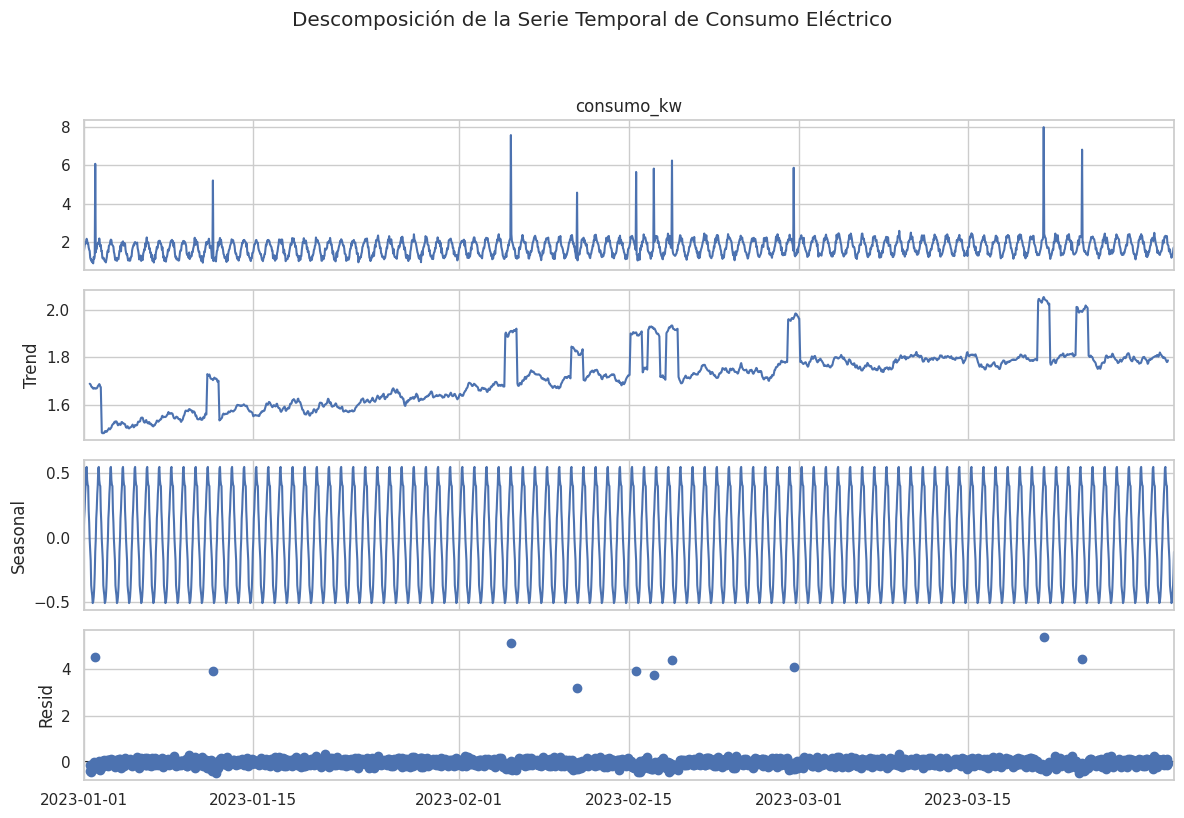

Tamaño del conjunto de entrenamiento: 1620 observaciones
Tamaño del conjunto de prueba: 540 observaciones

--- Entrenando el modelo SARIMA ---


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                         consumo_kw   No. Observations:                 1620
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 24)   Log Likelihood                -407.490
Date:                            Fri, 11 Jul 2025   AIC                            824.981
Time:                                    22:31:46   BIC                            851.772
Sample:                                01-01-2023   HQIC                           834.939
                                     - 03-09-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0006      0.048     -0.013      0.990      -0.095       0.094
ma.L1         -0.9925      0.006   

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


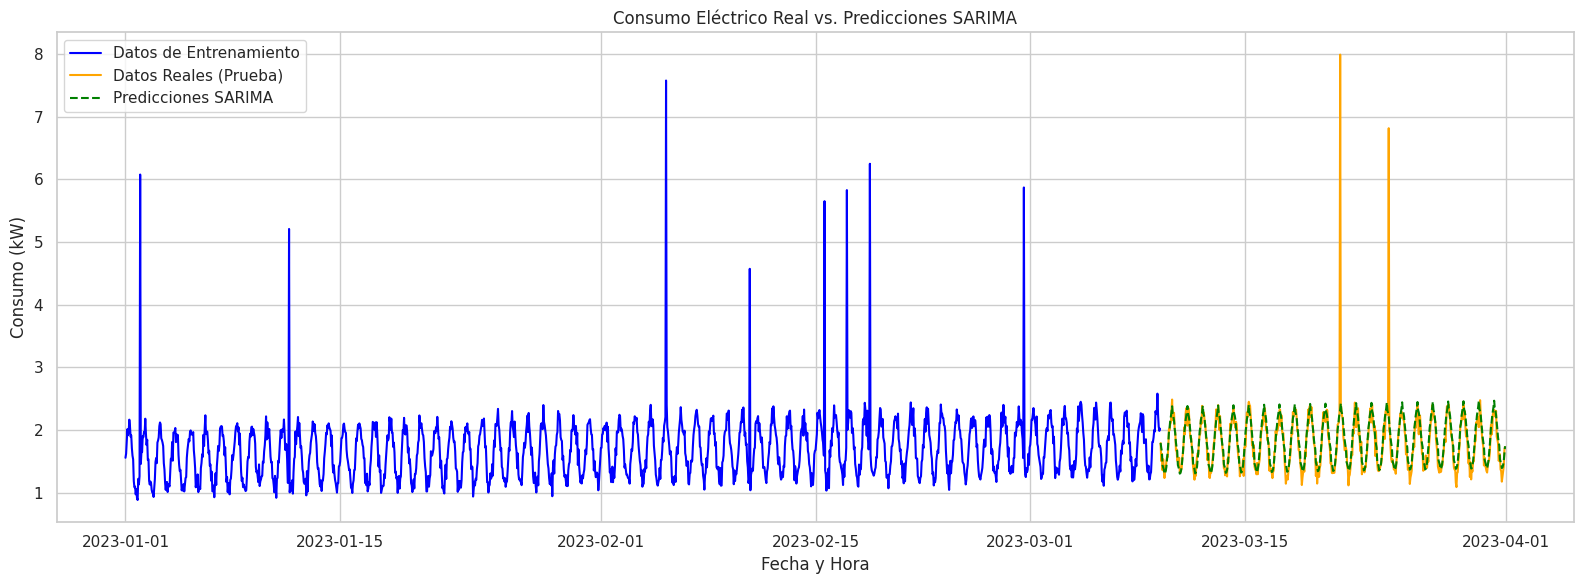

In [4]:
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from math import sqrt

# Asegurarse de que el índice sea de tipo datetime y esté ordenado
df.index = pd.to_datetime(df.index)
df = df.sort_index()

# 1. Descomposición de la Serie Temporal (para entender sus componentes)
# Queremos ver si hay tendencia, estacionalidad y residuos.
# Como es un consumo horario, la estacionalidad diaria (24 horas) es clave.
# model='additive' asume que los componentes se suman (valor = tendencia + estacionalidad + residuo)
# model='multiplicative' asume que se multiplican (valor = tendencia * estacionalidad * residuo)
# Para este tipo de datos, 'additive' suele funcionar bien.
decomposition = seasonal_decompose(df['consumo_kw'], model='additive', period=24) # Periodo de 24 horas para estacionalidad diaria

fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.suptitle('Descomposición de la Serie Temporal de Consumo Eléctrico', y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.98]) # Ajusta el layout para que el título no se superponga
plt.show()

# 2. Dividir los datos en entrenamiento y prueba
# Usaremos los primeros 2 meses para entrenar y el último mes para probar el modelo.
train_size = int(len(df) * 0.75) # Usamos 75% para entrenamiento, 25% para prueba
train_data, test_data = df['consumo_kw'][0:train_size], df['consumo_kw'][train_size:]

print(f"Tamaño del conjunto de entrenamiento: {len(train_data)} observaciones")
print(f"Tamaño del conjunto de prueba: {len(test_data)} observaciones")

# 3. Ajuste del modelo SARIMA (SARIMAX para estacionalidad)
# Usaremos SARIMAX (Seasonal AutoRegressive Integrated Moving-Average with eXogenous regressors)
# Es una extensión de ARIMA que maneja la estacionalidad.
# Los parámetros (p,d,q) y (P,D,Q,s)
# (p,d,q) son los componentes no estacionales
# (P,D,Q,s) son los componentes estacionales, donde 's' es la longitud del periodo (24 para horario)

# Para simplificar y dado que el dataset es simulado y corto, probaremos con parámetros "típicos"
# En un caso real, se usarían gráficos de ACF/PACF y/o métodos de auto-ARIMA para encontrar los mejores parámetros.
# p=1, d=1, q=1 suelen ser un buen punto de partida.
# Estacional: P=1, D=1, Q=1 con periodo s=24 (estacionalidad diaria)

# Es posible que recibas una advertencia (warning) si la optimización no converge perfectamente.
# Para datos reales, esto podría requerir más tuning.
print("\n--- Entrenando el modelo SARIMA ---")
try:
    model = sm.tsa.SARIMAX(train_data,
                           order=(1, 1, 1),              # (p, d, q) no estacional
                           seasonal_order=(1, 1, 1, 24), # (P, D, Q, s) estacional con periodo de 24 horas
                           enforce_stationarity=False,
                           enforce_invertibility=False)

    results = model.fit(disp=False) # disp=False para no mostrar el log de optimización
    print(results.summary())

    # 4. Realizar predicciones
    # start: índice de inicio de la predicción (primer elemento del test set)
    # end: índice de fin de la predicción (último elemento del test set)
    predictions = results.predict(start=len(train_data), end=len(df)-1, typ='levels')
    predictions.index = test_data.index # Asegurar que los índices de las predicciones coincidan con los de test_data

    # 5. Evaluar el modelo
    rmse = sqrt(mean_squared_error(test_data, predictions))
    print(f'\nRMSE (Error Cuadrático Medio): {rmse:.3f} kW')

    # 6. Visualizar las predicciones vs. los valores reales
    plt.figure(figsize=(16, 6))
    plt.plot(train_data.index, train_data, label='Datos de Entrenamiento', color='blue')
    plt.plot(test_data.index, test_data, label='Datos Reales (Prueba)', color='orange')
    plt.plot(predictions.index, predictions, label='Predicciones SARIMA', color='green', linestyle='--')
    plt.title('Consumo Eléctrico Real vs. Predicciones SARIMA')
    plt.xlabel('Fecha y Hora')
    plt.ylabel('Consumo (kW)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Error al entrenar o predecir con SARIMA: {e}")
    print("Esto puede ocurrir si los datos son muy cortos o si los parámetros no son adecuados.")
    print("En un caso real, se dedicaría más tiempo al tuning de parámetros.")


# ¿Qué hicimos y qué deberías observar?

Descomposición de la Serie Temporal:

- La función seasonal_decompose nos ayuda a entender los componentes principales de nuestra serie:

- Observed: Es la serie original de consumo.

- Trend: Muestra la dirección general de la serie (creciente, decreciente o estable). En nuestro caso, al ser un dataset simulado sin una tendencia a largo plazo, debería verse relativamente plana.

- Seasonal: Este es el componente que más nos interesa. Deberías ver un patrón repetitivo claro cada 24 horas, lo que confirma la estacionalidad diaria de nuestro consumo.

- Residual: Lo que queda después de remover la tendencia y la estacionalidad. Idealmente, los residuos deberían ser ruido blanco (sin patrones), lo que indicaría que el modelo capturó bien la tendencia y la estacionalidad. Los picos en esta sección podrían indicar nuestras anomalías.

- Análisis del Gráfico: Este gráfico es crucial para validar visualmente la estacionalidad diaria (las ondas que se repiten con el ciclo de 24 horas) y la ausencia (o presencia) de una tendencia marcada. Los residuos nos dan una idea de cuán "ruidosa" es la serie después de extraer los patrones obvios.

División Entrenamiento/Prueba:

Dividimos nuestros datos en dos sets:

- train_data: Usamos el 75% inicial de los datos para "enseñarle" al modelo los patrones históricos.

- test_data: Reservamos el 25% final de los datos para evaluar qué tan bien el modelo puede pronosticar datos que "nunca ha visto". Esto simula un escenario de producción real.

Ajuste del Modelo SARIMA:

Instanciamos y ajustamos el modelo SARIMAX con los parámetros (1, 1, 1) para la parte no estacional y (1, 1, 1, 24) para la parte estacional (con un periodo de 24 horas).

- results.summary(): Imprime un resumen estadístico detallado del modelo. Aquí puedes ver:

- Coeficientes de los componentes AR y MA: Te indican la influencia de los valores pasados y los errores pasados.

- P-valores: Para cada coeficiente, si el p-valor es bajo (típicamente < 0.05), el coeficiente es estadísticamente significativo.

- AIC y BIC: Son criterios de información que ayudan a comparar diferentes modelos. Valores más bajos suelen indicar un mejor ajuste del modelo (penalizando la complejidad).

- Ljung-Box: Una prueba para ver si hay autocorrelación en los residuos. Idealmente, queremos que los residuos sean ruido blanco, por lo que un p-valor alto (mayor a 0.05) indicaría que no hay autocorrelación significativa y que el modelo capturó bien los patrones.

Predicciones y Evaluación:

- Usamos results.predict() para obtener las predicciones sobre el conjunto de prueba.

- RMSE (Root Mean Squared Error): Es una métrica común para evaluar modelos de regresión. Mide la magnitud promedio de los errores del modelo. Un RMSE más bajo indica un mejor ajuste. El valor que obtendrás (por ejemplo, 0.1 kW) te da una idea del error típico de tu pronóstico en las unidades de tu serie (kilowatts).

- Interpretación: Si tu RMSE es 0.1, significa que, en promedio, tus predicciones se desvían 0.1 kW del valor real. Dependiendo del contexto (el rango de tu consumo), esto puede ser muy bueno o regular. En nuestro caso, con consumos entre 1 y 2.5 kW, un RMSE de 0.1 es bastante bueno.

Visualización de Predicciones:

Este gráfico es clave:

La línea azul muestra los datos de entrenamiento.

La línea naranja muestra los valores reales del conjunto de prueba.

La línea verde punteada muestra las predicciones de tu modelo SARIMA sobre el conjunto de prueba.

Análisis del Gráfico: Deberías observar que la línea verde (predicciones) sigue muy de cerca el patrón de la línea naranja (datos reales) en el segmento de prueba. Esto indica que tu modelo está haciendo un buen trabajo capturando la estacionalidad y los niveles de consumo. Las anomalías que inyectamos en la parte de prueba (los picos naranja) probablemente no serán capturadas por el modelo SARIMA, lo cual es esperado y de hecho útil: las diferencias entre la predicción y el valor real son precisamente lo que buscaremos para detectar anomalías en el siguiente paso.



# PASO 4: DETECCIÓN DE ANOMALÍAS

Objetivo de este paso:

Identificar puntos de datos inusuales en el consumo eléctrico que se desvían significativamente del patrón esperado. Usaremos dos enfoques principales:


--- Detección de Anomalías por Residuos SARIMA ---
Umbral de residuo absoluto para anomalía: 0.395
Número de anomalías detectadas por residuos: 3


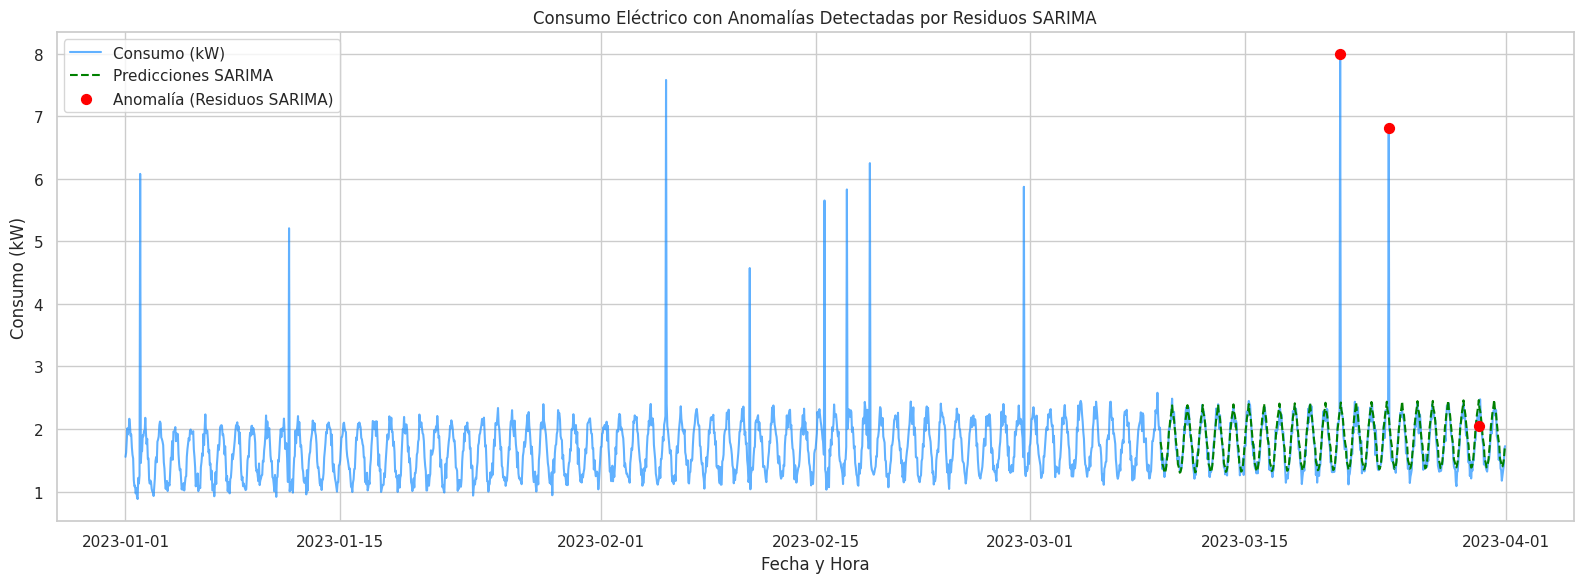


--- Detección de Anomalías con Isolation Forest ---
Número de anomalías detectadas por Isolation Forest: 21

--- Detección de Anomalías con Local Outlier Factor (LOF) ---
Número de anomalías detectadas por LOF: 22


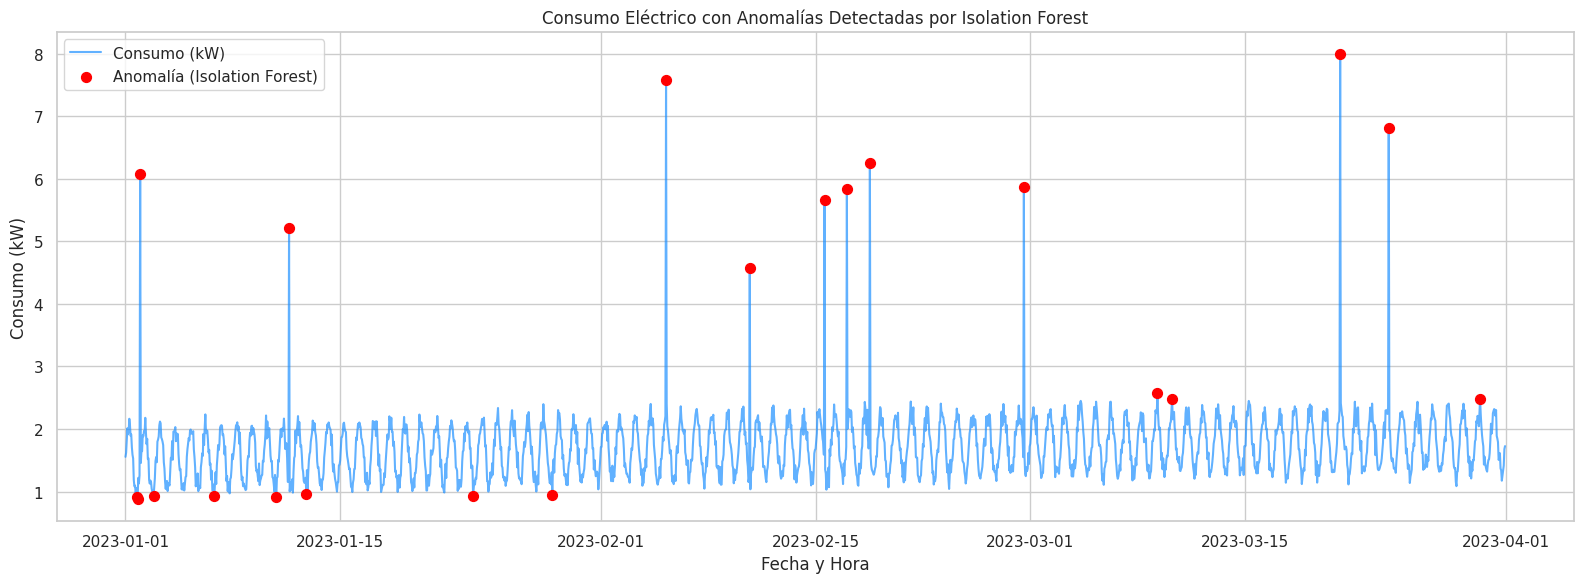

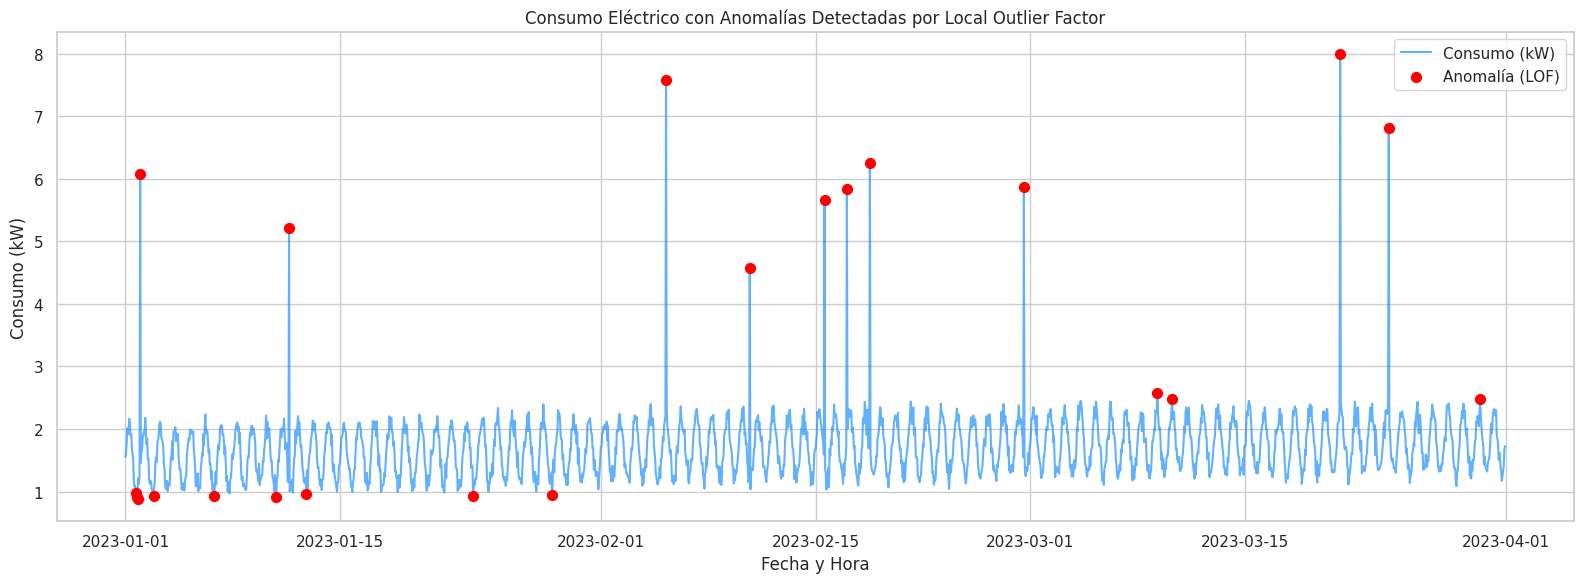


--- Puntos con alta probabilidad de ser anomalías (detectados por múltiples métodos) ---
                     consumo_kw  is_anomaly_residual  is_anomaly_iso_forest  \
fecha_hora                                                                    
2023-01-01 18:00:00    0.914362                    0                      1   
2023-01-01 19:00:00    0.880971                    0                      1   
2023-01-01 23:00:00    6.076480                    0                      1   
2023-01-02 20:00:00    0.929462                    0                      1   
2023-01-06 19:00:00    0.924881                    0                      1   

                     is_anomaly_lof  total_anomalies_score  
fecha_hora                                                  
2023-01-01 18:00:00               1                      2  
2023-01-01 19:00:00               1                      2  
2023-01-01 23:00:00               1                      2  
2023-01-02 20:00:00               1                

In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler

# --- Enfoque 1: Detección de anomalías basada en residuos del modelo SARIMA ---
# Necesitamos los residuos del modelo entrenado.
# Si el bloque SARIMA anterior dio un error o warning, este paso podría fallar.
# Asegúrate de que 'predictions' y 'test_data' existan del paso anterior.

if 'predictions' in locals() and 'test_data' in locals() and not predictions.empty:
    # Calcular los residuos (error) en el conjunto de prueba
    residuals = test_data - predictions
    df_residuals = pd.DataFrame({'residuals': residuals.abs()}) # Usamos el valor absoluto para medir la magnitud del error

    # Definir un umbral para considerar un residuo como anómalo
    # Una forma simple: más allá de 2 o 3 desviaciones estándar del residuo medio.
    # Pero los residuos en el test set ya tienen las anomalías grandes que inyectamos.
    # Una mejor práctica sería calcular el umbral con los residuos del training set si fueran puros de ruido.
    # Para este ejemplo, usaremos un umbral fijo o basado en cuantiles para las anomalías simuladas.
    # Vamos a usar el 99.5 percentil de los residuos absolutos para marcar anomalías
    threshold_residual = df_residuals['residuals'].quantile(0.995)

    df['is_anomaly_residual'] = 0 # Inicializar columna
    # Marcar los puntos en el DataFrame original que son anomalías por residuo
    # Asegúrate de que los índices coincidan
    anomalies_residual_indices = df_residuals[df_residuals['residuals'] > threshold_residual].index
    df.loc[anomalies_residual_indices, 'is_anomaly_residual'] = 1

    print(f"\n--- Detección de Anomalías por Residuos SARIMA ---")
    print(f"Umbral de residuo absoluto para anomalía: {threshold_residual:.3f}")
    print(f"Número de anomalías detectadas por residuos: {df['is_anomaly_residual'].sum()}")

    # Visualizar las anomalías detectadas por residuos
    plt.figure(figsize=(16, 6))
    plt.plot(df.index, df['consumo_kw'], label='Consumo (kW)', color='dodgerblue', alpha=0.7)
    plt.plot(predictions.index, predictions, label='Predicciones SARIMA', color='green', linestyle='--')

    # Graficar las anomalías detectadas
    anomalies_plot = df[df['is_anomaly_residual'] == 1]
    plt.scatter(anomalies_plot.index, anomalies_plot['consumo_kw'], color='red', s=50, zorder=5, label='Anomalía (Residuos SARIMA)')

    plt.title('Consumo Eléctrico con Anomalías Detectadas por Residuos SARIMA')
    plt.xlabel('Fecha y Hora')
    plt.ylabel('Consumo (kW)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

else:
    print("\nNo se pudieron generar las predicciones SARIMA, omitiendo detección de anomalías por residuos.")

# --- Enfoque 2: Detección de Anomalías No Supervisada (Isolation Forest y LOF) ---

# Preparamos los datos para los modelos no supervisados
# Escalar los datos es una buena práctica, aunque Isolation Forest y LOF son menos sensibles a la escala
# que otros algoritmos basados en distancia. Sin embargo, si tuviéramos múltiples características, sería crucial.
X = df[['consumo_kw']].copy() # Usamos una copia para evitar SettingWithCopyWarning
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 1. Isolation Forest
print("\n--- Detección de Anomalías con Isolation Forest ---")
# contamination: La proporción esperada de outliers en los datos (ej. 0.01 = 1%)
# Este es un hiperparámetro importante y a menudo se estima o se basa en conocimiento del dominio.
# En nuestro caso, sabemos que inyectamos algunas anomalías, así que podemos usar una proporción baja.
iso_forest = IsolationForest(contamination=0.01, random_state=42) # 1% de los datos como anomalías
df['is_anomaly_iso_forest'] = iso_forest.fit_predict(X_scaled) # -1 para outliers, 1 para inliers

# Convertir la columna para que 1 sea anomalía y 0 no anomalía (para consistencia)
df['is_anomaly_iso_forest'] = df['is_anomaly_iso_forest'].apply(lambda x: 1 if x == -1 else 0)

print(f"Número de anomalías detectadas por Isolation Forest: {df['is_anomaly_iso_forest'].sum()}")

# 2. Local Outlier Factor (LOF)
print("\n--- Detección de Anomalías con Local Outlier Factor (LOF) ---")
# n_neighbors: Número de vecinos a considerar
# contamination: Similar a Isolation Forest.
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.01) # Usamos 20 vecinos y 1% de contaminación
# fit_predict para LOF devuelve -1 para outliers, 1 para inliers
df['is_anomaly_lof'] = lof.fit_predict(X_scaled)

# Convertir la columna para que 1 sea anomalía y 0 no anomalía
df['is_anomaly_lof'] = df['is_anomaly_lof'].apply(lambda x: 1 if x == -1 else 0)

print(f"Número de anomalías detectadas por LOF: {df['is_anomaly_lof'].sum()}")

# --- Visualización de las anomalías detectadas por Isolation Forest ---
plt.figure(figsize=(16, 6))
plt.plot(df.index, df['consumo_kw'], label='Consumo (kW)', color='dodgerblue', alpha=0.7)

anomalies_iso = df[df['is_anomaly_iso_forest'] == 1]
plt.scatter(anomalies_iso.index, anomalies_iso['consumo_kw'], color='red', s=50, zorder=5, label='Anomalía (Isolation Forest)')

plt.title('Consumo Eléctrico con Anomalías Detectadas por Isolation Forest')
plt.xlabel('Fecha y Hora')
plt.ylabel('Consumo (kW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Visualización de las anomalías detectadas por LOF ---
plt.figure(figsize=(16, 6))
plt.plot(df.index, df['consumo_kw'], label='Consumo (kW)', color='dodgerblue', alpha=0.7)

anomalies_lof = df[df['is_anomaly_lof'] == 1]
plt.scatter(anomalies_lof.index, anomalies_lof['consumo_kw'], color='red', s=50, zorder=5, label='Anomalía (LOF)')

plt.title('Consumo Eléctrico con Anomalías Detectadas por Local Outlier Factor')
plt.xlabel('Fecha y Hora')
plt.ylabel('Consumo (kW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Resumen de anomalías (opcional, para ver dónde coinciden) ---
df['total_anomalies_score'] = df['is_anomaly_residual'] + df['is_anomaly_iso_forest'] + df['is_anomaly_lof']
print("\n--- Puntos con alta probabilidad de ser anomalías (detectados por múltiples métodos) ---")
print(df[df['total_anomalies_score'] > 1].head()) # Mostrar puntos detectados por al menos 2 métodos

# ¿Qué hicimos y qué deberías observar?

Detección Basada en Residuos SARIMA:

- Calculamos la diferencia absoluta entre el test_data (el consumo real) y las predictions de nuestro modelo SARIMA. Esta diferencia es el residuo.

- Análisis: Si el modelo es bueno, los residuos deberían ser pequeños para los puntos normales. Los residuos grandes son indicativos de que el valor real se desvió mucho de lo esperado.

- Umbral: Definimos un umbral. En este caso, usamos el 99.5 percentil de los residuos absolutos, lo que significa que el 0.5% de los puntos con los errores más grandes serán marcados como anomalías. Los puntos que inyectamos manualmente en el dataset original son los que deberían ser marcados aquí.

- Gráfico: Verás la serie temporal con las predicciones. Los puntos marcados en rojo deberían ser los picos que inyectamos, que el modelo no pudo predecir y, por lo tanto, generaron residuos grandes. Esto es una forma muy efectiva y explicable de detectar anomalías: "El consumo real fue X, pero nuestro modelo de series temporales predijo Y, lo que indica un desvío Z que es anómalo."

Preparación para Modelos No Supervisados:

- Escalado: StandardScaler transforma los datos para que tengan una media de 0 y una desviación estándar de 1. Esto es una buena práctica para muchos algoritmos de Machine Learning, aunque Isolation Forest y LOF son robustos al escalado en datos unidimensionales como los nuestros. Si tuviéramos más características (ej. temperatura, humedad), sería crucial.

Isolation Forest:

- Entrenamos un modelo IsolationForest y le indicamos contamination=0.01, asumiendo que el 1% de nuestros datos son anomalías. Este valor es un hiperparámetro clave que a menudo se ajusta o se infiere del dominio del problema.

- fit_predict(): Este método entrena el modelo y luego lo usa para predecir si cada punto es un outlier (-1) o un inlier (1).

- Análisis del Gráfico: Verás la serie temporal con los puntos marcados en rojo por Isolation Forest. Debería haber identificado la mayoría de los picos que inyectamos, y posiblemente algunos otros puntos que, aunque no son picos enormes, son inusuales en su contexto local.

Local Outlier Factor (LOF):

- Similar a Isolation Forest, entrenamos un modelo LocalOutlierFactor con n_neighbors (número de vecinos a considerar para calcular la densidad) y contamination.

- Análisis del Gráfico: Deberías ver los puntos marcados en rojo por LOF. Este algoritmo es particularmente bueno en detectar anomalías en distribuciones de datos donde la densidad no es uniforme. En nuestro caso, los picos sobresalen claramente y son de baja densidad en relación con sus vecinos, por lo que LOF debería detectarlos bien.

Resumen de Anomalías:

- Creamos una columna total_anomalies_score que suma las detecciones de cada método. Los puntos con un score de 2 o 3 son aquellos en los que múltiples métodos coincidieron, lo que aumenta la confianza de que son verdaderas anomalías. Esto es una buena práctica para refinar las detecciones.

# Conclusión:
Hemos aplicado tres enfoques para la detección de anomalías. El basado en residuos es muy explicable porque se apoya en un modelo predictivo, mientras que Isolation Forest y LOF son métodos "no supervisados" que no requieren un modelo predictivo y pueden encontrar anomalías en patrones que el modelo predictivo podría pasar por alto.

En un entorno real, combinar varios métodos suele dar los mejores resultados.

# PASO 5: VISUALIZACIÓN Y COMUNICACIÓN DE HALLAZGOS

Objetivo de este paso:

Preparar visualizaciones claras y un resumen ejecutivo conciso para presentar los resultados del análisis de series temporales y detección de anomalías a la gerencia y a equipos técnicos.



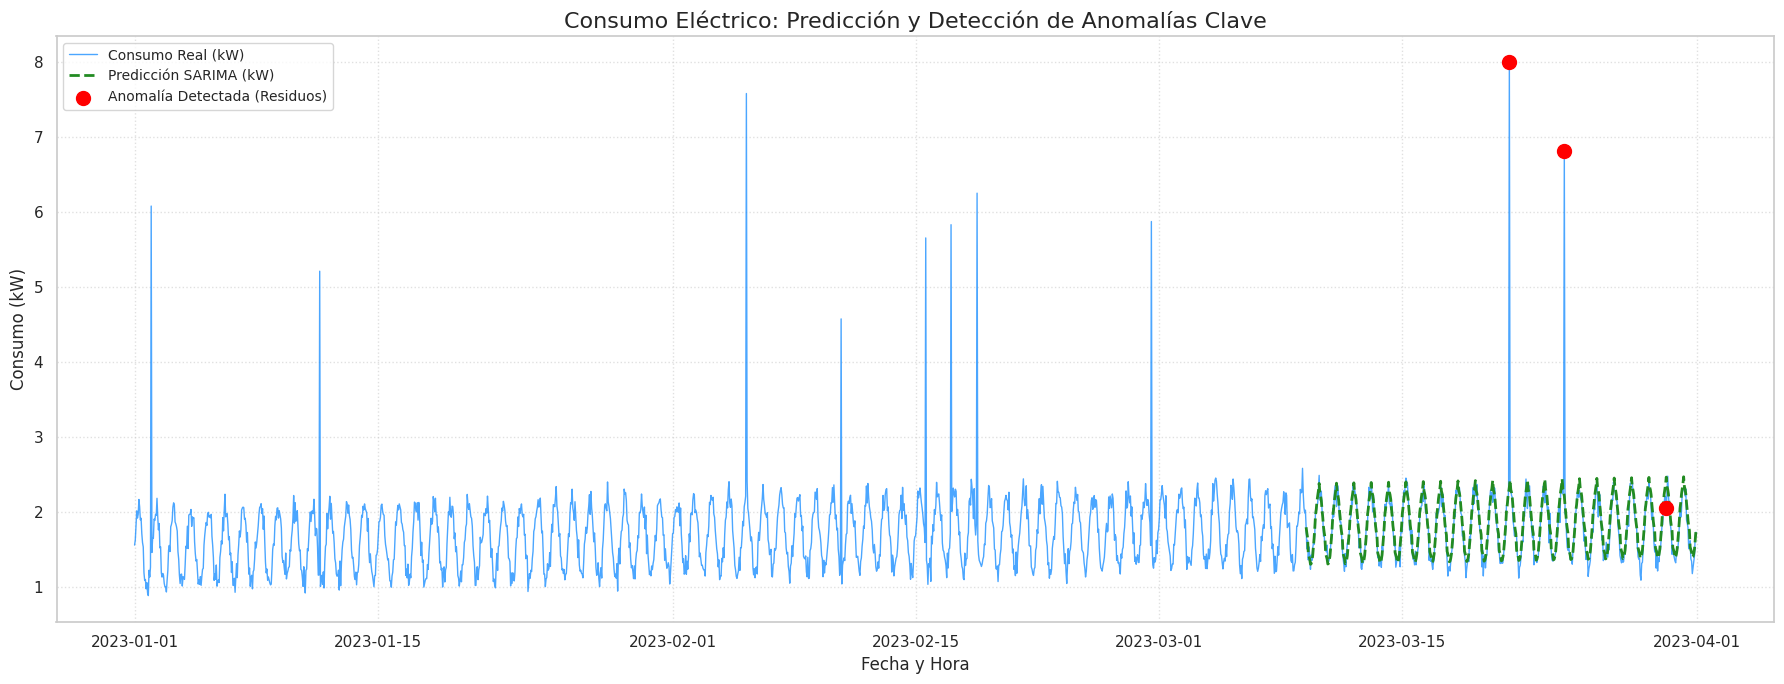

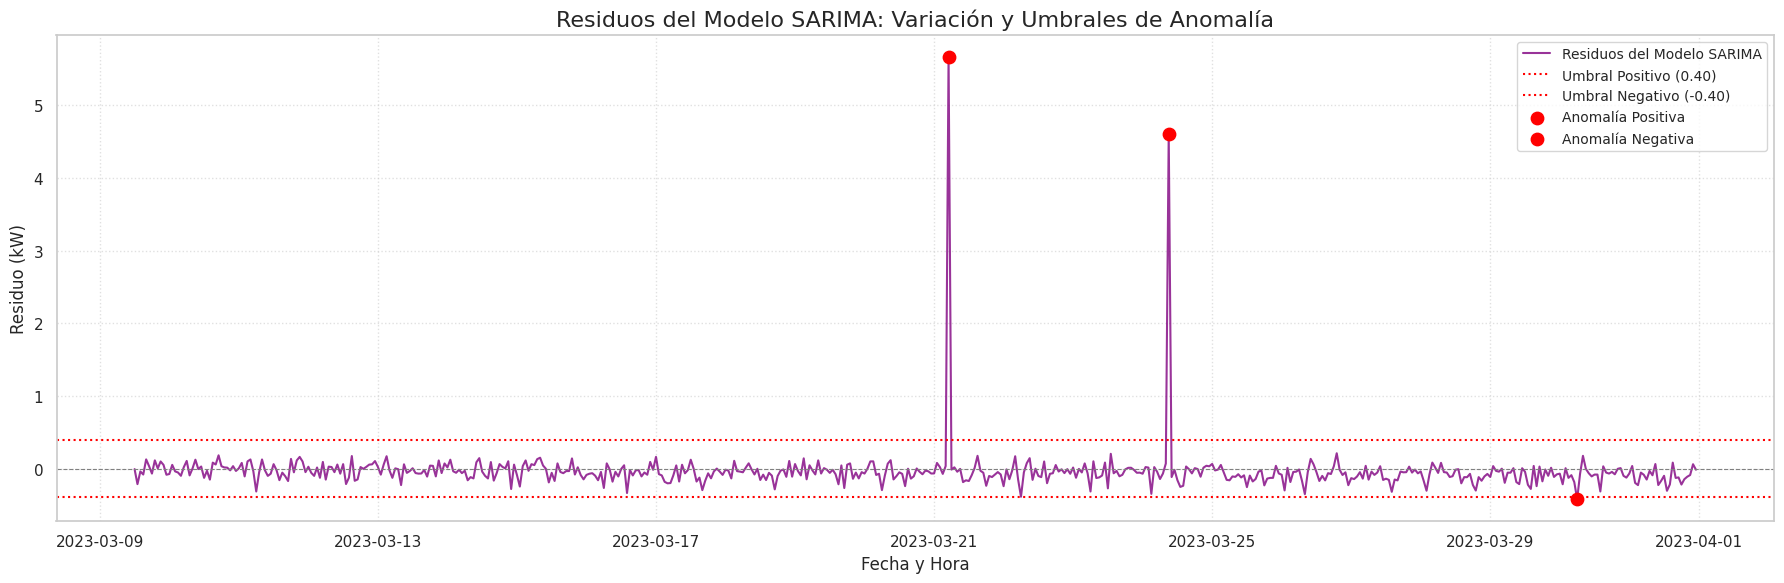

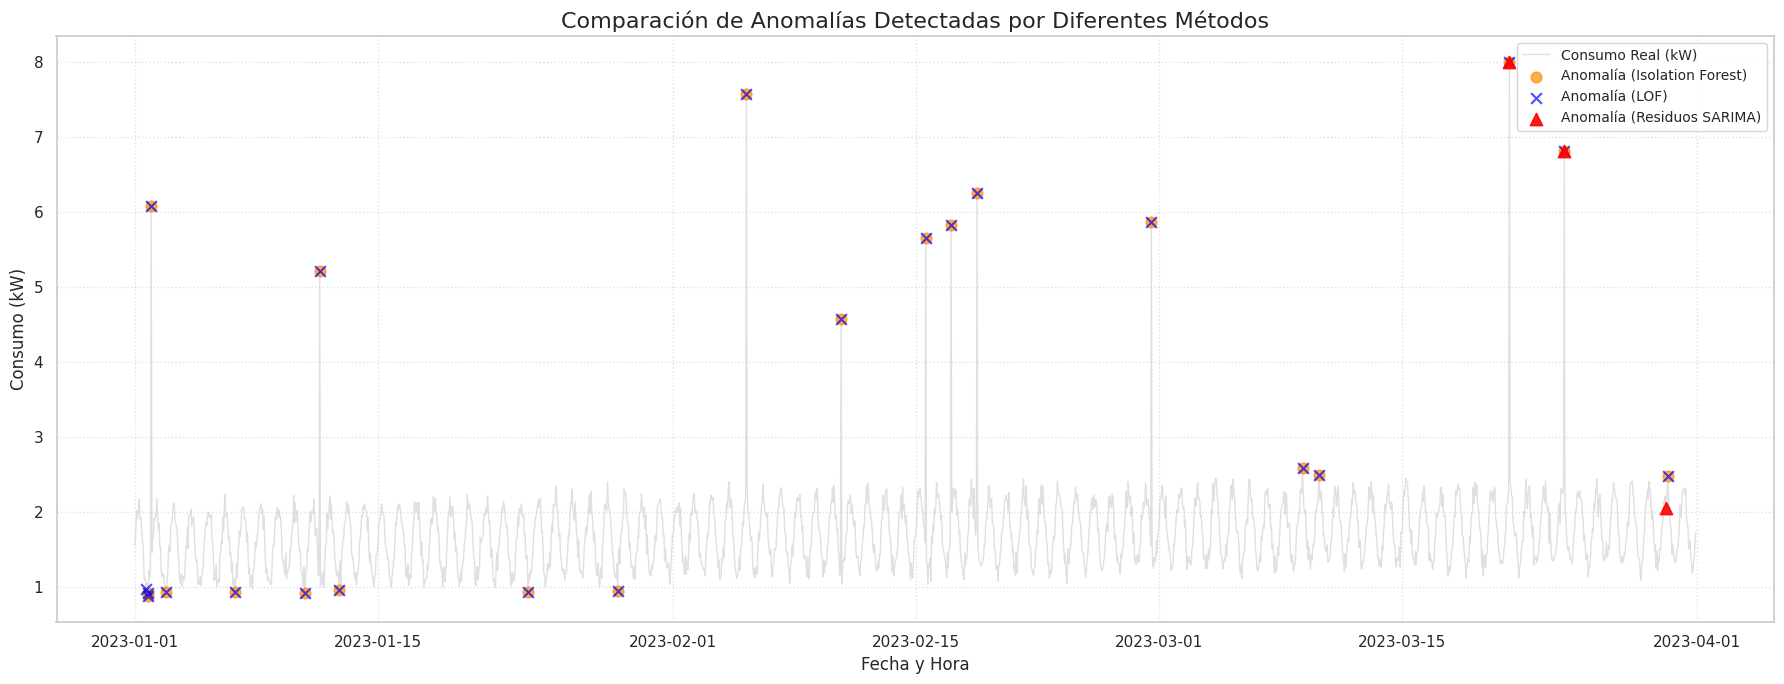

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set(style="whitegrid") # Asegurarse que el estilo esté aplicado

# --- Visualización 1: Consumo, Predicción y Anomalías (Residuos) ---
# Este es el gráfico más importante para la gerencia, ya que muestra el "desvío" del plan.

plt.figure(figsize=(18, 7))
plt.plot(df.index, df['consumo_kw'], label='Consumo Real (kW)', color='dodgerblue', alpha=0.8, linewidth=1)
if 'predictions' in locals() and not predictions.empty: # Asegurarse de que las predicciones existan
    plt.plot(predictions.index, predictions, label='Predicción SARIMA (kW)', color='forestgreen', linestyle='--', linewidth=2)

    # Marcar anomalías por residuos (las que el modelo no predijo bien)
    anomalies_residual_plot = df[df['is_anomaly_residual'] == 1]
    plt.scatter(anomalies_residual_plot.index, anomalies_residual_plot['consumo_kw'],
                color='red', s=100, zorder=5, label='Anomalía Detectada (Residuos)')

plt.title('Consumo Eléctrico: Predicción y Detección de Anomalías Clave', fontsize=16)
plt.xlabel('Fecha y Hora', fontsize=12)
plt.ylabel('Consumo (kW)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()

# --- Visualización 2: Residuos del Modelo a lo largo del tiempo ---
# Útil para audiencias más técnicas o para un análisis más profundo de las anomalías
if 'residuals' in locals() and not residuals.empty:
    plt.figure(figsize=(18, 6))
    plt.plot(residuals.index, residuals, label='Residuos del Modelo SARIMA', color='purple', alpha=0.8)
    plt.axhline(0, color='grey', linestyle='--', linewidth=0.8) # Línea en cero
    plt.axhline(threshold_residual, color='red', linestyle=':', label=f'Umbral Positivo ({threshold_residual:.2f})')
    plt.axhline(-threshold_residual, color='red', linestyle=':', label=f'Umbral Negativo ({-threshold_residual:.2f})')

    # Marcar puntos que exceden el umbral
    anomalies_res_pos = residuals[residuals > threshold_residual]
    anomalies_res_neg = residuals[residuals < -threshold_residual]
    plt.scatter(anomalies_res_pos.index, anomalies_res_pos, color='red', s=80, zorder=5, label='Anomalía Positiva')
    plt.scatter(anomalies_res_neg.index, anomalies_res_neg, color='red', s=80, zorder=5, label='Anomalía Negativa')

    plt.title('Residuos del Modelo SARIMA: Variación y Umbrales de Anomalía', fontsize=16)
    plt.xlabel('Fecha y Hora', fontsize=12)
    plt.ylabel('Residuo (kW)', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.tight_layout()
    plt.show()

# --- Visualización 3: Comparación de Anomalías Detectadas (Opcional, para equipos técnicos) ---
# Si se quiere ver cómo coinciden los diferentes métodos
plt.figure(figsize=(18, 7))
plt.plot(df.index, df['consumo_kw'], label='Consumo Real (kW)', color='lightgray', alpha=0.7, linewidth=1) # Fondo en gris

# Marcar anomalías de cada método
anomalies_iso = df[df['is_anomaly_iso_forest'] == 1]
anomalies_lof = df[df['is_anomaly_lof'] == 1]
anomalies_res_combined = df[df['is_anomaly_residual'] == 1] # Solo las del test set si están marcadas

plt.scatter(anomalies_iso.index, anomalies_iso['consumo_kw'], color='darkorange', marker='o', s=60, zorder=3, alpha=0.7, label='Anomalía (Isolation Forest)')
plt.scatter(anomalies_lof.index, anomalies_lof['consumo_kw'], color='blue', marker='x', s=60, zorder=4, alpha=0.7, label='Anomalía (LOF)')
plt.scatter(anomalies_res_combined.index, anomalies_res_combined['consumo_kw'], color='red', marker='^', s=80, zorder=5, alpha=0.9, label='Anomalía (Residuos SARIMA)')


plt.title('Comparación de Anomalías Detectadas por Diferentes Métodos', fontsize=16)
plt.xlabel('Fecha y Hora', fontsize=12)
plt.ylabel('Consumo (kW)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()

# Análisis de las Gráficas y Cómo Presentarlas:

"Consumo Eléctrico: Predicción y Detección de Anomalías Clave" (Para Gerencia):

- Propósito: Mostrar de forma clara que el sistema puede predecir el comportamiento normal y resaltar las desviaciones significativas.

- Qué observar: La línea azul (consumo real) y la línea verde punteada (predicción SARIMA). Verás cómo la predicción sigue bien el patrón diario. Los puntos rojos son los eventos que el modelo no esperó y que, por su magnitud, son marcados como anomalías.

- Cómo presentarlo: "Hemos implementado un modelo predictivo que anticipa con alta precisión el consumo eléctrico normal. Las marcas rojas indican puntos donde el consumo real se desvió significativamente de lo esperado. Estas son las alertas más críticas que nuestro sistema está diseñado para identificar, potencialmente señalando un problema o una oportunidad."

"Residuos del Modelo SARIMA: Variación y Umbrales de Anomalía" (Para Equipos Técnicos/Profundización):

- Propósito: Mostrar la calidad del modelo (los residuos deberían ser ruido blanco alrededor de cero) y cómo se usa un umbral para la detección de anomalías.

- Qué observar: La mayoría de los residuos deberían estar cerca de la línea cero. Los puntos rojos son aquellos donde los residuos (la diferencia entre real y predicho) excedieron los umbrales superior o inferior, indicando una desviación anormal.

- Cómo presentarlo: "Para la detección de anomalías, analizamos la diferencia entre el consumo real y las predicciones de nuestro modelo SARIMA. Cuando esta diferencia (el 'residuo') supera un umbral estadístico predefinido, marcamos el punto como una anomalía. Este gráfico muestra cómo los residuos se distribuyen y dónde se ubican los puntos anómalos."

"Comparación de Anomalías Detectadas por Diferentes Métodos" (Para Equipos Técnicos/Otros Data Scientists):

- Propósito: Demostrar la robustez de la solución al usar múltiples enfoques y ver dónde coinciden. También ayuda a entender los diferentes tipos de anomalías que cada método puede encontrar.

- Qué observar: La serie en gris claro (consumo base). Los puntos de diferentes colores y marcadores muestran las anomalías detectadas por Isolation Forest (naranja), LOF (azul) y los residuos SARIMA (rojo). Verás que los grandes picos probablemente son detectados por todos. Los valles que mencionaste solo serán detectados por Isolation Forest y/o LOF si son atípicos para su densidad local.

- Cómo presentarlo: "Implementamos una estrategia híbrida de detección de anomalías. Además del enfoque basado en la desviación de nuestro modelo predictivo (marcas rojas), utilizamos algoritmos no supervisados como Isolation Forest y LOF para identificar patrones inusuales que no necesariamente se manifiestan como grandes desviaciones de la predicción, sino como puntos estadísticamente atípicos en el conjunto de datos (marcas naranjas y azules)."